# 🛰️ 1. Installing Required Libraries

In [1]:
# Install the Earth Engine Python API
!pip install earthengine-api geemap --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.5 MB/s eta 0:00:00


# 🔧 2. Importing Libraries

In [2]:
import ee
import geemap
import matplotlib.pyplot as plt

# 🔐 3. Initialize Earth Engine

In [5]:
# Initialize Earth Engine
try:
    ee.Initialize(project='gen-lang-client-0219770664')
except Exception:
    ee.Authenticate()
    ee.Initialize(project='gen-lang-client-0219770664')

# 📍 4. Define Area of Interest (AOI)

In [6]:
# Define the area of interest (Bandar Anzali, Iran)
bandar_anzali = ee.Geometry.Point([49.4579, 37.4724]).buffer(10000)  # 10km buffer around the city center

# 🌤️ 5. Define Function to Get Landsat Data

In [7]:
# Function to get cloud-free Landsat imagery
def get_landsat_collection():
    # Get Landsat 8 TOA collection
    collection = (ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')
                 .filterBounds(bandar_anzali)
                 .filterDate('2025-01-01', '2025-03-30')
                 .sort('CLOUD_COVER')
                 .first())
    return collection

## 🛰️ What is **Landsat 8**?

**Landsat 8** is a **satellite** in the long-running **Landsat program**, which is a joint mission by **NASA** and the **USGS (U.S. Geological Survey)** to monitor Earth’s land surfaces using remote sensing.

It was **launched in 2013** and provides **high-quality imagery** of the Earth's surface every **16 days**.

---

### 📷 What does it capture?

Landsat 8 carries **two main instruments**:

1. **OLI (Operational Land Imager)** — captures visible, near-infrared, and shortwave infrared bands.
2. **TIRS (Thermal Infrared Sensor)** — captures thermal (heat) data.

It captures **11 spectral bands**, including:

* **Band 2–4**: Blue, Green, Red → used for true color
* **Band 5**: Near Infrared → vegetation analysis (NDVI)
* **Band 6–7**: SWIR → soil, water content, fire detection
* **Band 10–11**: Thermal infrared → surface temperature

---

## 🔢 Are there other Landsat numbers?

Yes! The **Landsat program** has been running since **1972**, and here’s a quick overview:

| Satellite     | Launched | Status         | Notes                                                |
| ------------- | -------- | -------------- | ---------------------------------------------------- |
| Landsat 1     | 1972     | Retired        | First in the series                                  |
| Landsat 2     | 1975     | Retired        |                                                      |
| Landsat 3     | 1978     | Retired        |                                                      |
| Landsat 4     | 1982     | Retired        | Introduced Thematic Mapper                           |
| Landsat 5     | 1984     | Retired (2013) | Longest operating Earth-observing satellite          |
| Landsat 6     | 1993     | Launch failed  | 😢                                                   |
| Landsat 7     | 1999     | Still active   | Has a scan line corrector error (SLC-off) since 2003 |
| **Landsat 8** | **2013** | ✅ Active       | Main satellite used in many analyses                 |
| **Landsat 9** | **2021** | ✅ Active       | Very similar to Landsat 8, newer sensor calibration  |

---

### 🌐 In Google Earth Engine

You can access imagery from:

* `LANDSAT/LT05/...` → Landsat 5
* `LANDSAT/LE07/...` → Landsat 7
* `LANDSAT/LC08/...` → Landsat 8
* `LANDSAT/LC09/...` → Landsat 9




# 🌍 6. Fetch the Cleanest Image

In [8]:
# Get the satellite imagery
landsat = get_landsat_collection()

# 📈 7. Calculate Spectral Indices

* **NDVI:** vegetation health → `B5 (NIR)` and `B4 (Red)`

* **NDWI:** water bodies → `B3 (Green)` and `B5 (NIR)`

* **MNDWI:** improved water detection → `B3 (Green)` and `B6 (SWIR1)`

* Adds these as new bands to the image.

In [9]:
# Calculate the indices
def calculate_indices(image):
    # NDVI (Normalized Difference Vegetation Index)
    ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')

    # NDWI (Normalized Difference Water Index)
    ndwi = image.normalizedDifference(['B3', 'B5']).rename('NDWI')

    # MNDWI (Modified Normalized Difference Water Index)
    mndwi = image.normalizedDifference(['B3', 'B6']).rename('MNDWI')

    return image.addBands([ndvi, ndwi, mndwi])


## ✅ **Formulas for NDVI, NDWI, and MNDWI**

These are all **spectral indices** based on **Landsat bands**. They use a formula called **Normalized Difference**, which is generally:

$$
\text{Index} = \frac{A - B}{A + B}
$$

Where $A$ and $B$ are reflectance values from two spectral bands.

---

### 🌿 NDVI (Normalized Difference Vegetation Index)

**Formula:**

$$
\text{NDVI} = \frac{\text{NIR} - \text{RED}}{\text{NIR} + \text{RED}} = \frac{B5 - B4}{B5 + B4}
$$

* **B5 (NIR)** = Near Infrared (highly reflected by healthy vegetation)
* **B4 (RED)** = Red (absorbed by vegetation)

---

### 💧 NDWI (Normalized Difference Water Index)

**Formula:**

$$
\text{NDWI} = \frac{\text{GREEN} - \text{NIR}}{\text{GREEN} + \text{NIR}} = \frac{B3 - B5}{B3 + B5}
$$

* **B3 (GREEN)** = Green light
* **B5 (NIR)** = Near Infrared

---

### 🌊 MNDWI (Modified NDWI)

**Formula:**

$$
\text{MNDWI} = \frac{\text{GREEN} - \text{SWIR1}}{\text{GREEN} + \text{SWIR1}} = \frac{B3 - B6}{B3 + B6}
$$

* **B3 (GREEN)** = Green light
* **B6 (SWIR1)** = Shortwave Infrared


# 📊 8. Apply Indices to Image


In [10]:
# Apply the indices calculation
landsat_with_indices = calculate_indices(landsat)

# 🗺️ 9. Create an Interactive Map

In [11]:
# Create a map
map_anzali = geemap.Map()
map_anzali.centerObject(bandar_anzali, 11)

# Add the base map
map_anzali.add_basemap('HYBRID')

# 🌈 10. Add Visual Layers

In [12]:
# Add the true color image as a layer
true_color_viz = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 0.3,
}
map_anzali.addLayer(landsat, true_color_viz, 'True Color Image')

# Add NDVI layer
ndvi_viz = {
    'min': -1,
    'max': 1,
    'palette': ['blue', 'white', 'green']
}
map_anzali.addLayer(landsat_with_indices.select('NDVI'), ndvi_viz, 'NDVI', False)

# Add NDWI layer
ndwi_viz = {
    'min': -1,
    'max': 1,
    'palette': ['red', 'white', 'blue']
}
map_anzali.addLayer(landsat_with_indices.select('NDWI'), ndwi_viz, 'NDWI', False)

# Add MNDWI layer
mndwi_viz = {
    'min': -1,
    'max': 1,
    'palette': ['brown', 'white', 'cyan']
}
map_anzali.addLayer(landsat_with_indices.select('MNDWI'), mndwi_viz, 'MNDWI', False)

# Add the layers control panel
map_anzali.add_layer_manager()

# Display the map
display(map_anzali)

Map(center=[37.47241025887367, 49.457900358462396], controls=(WidgetControl(options=['position', 'transparent_…

# 🖼️ 11. Static Image Export Function

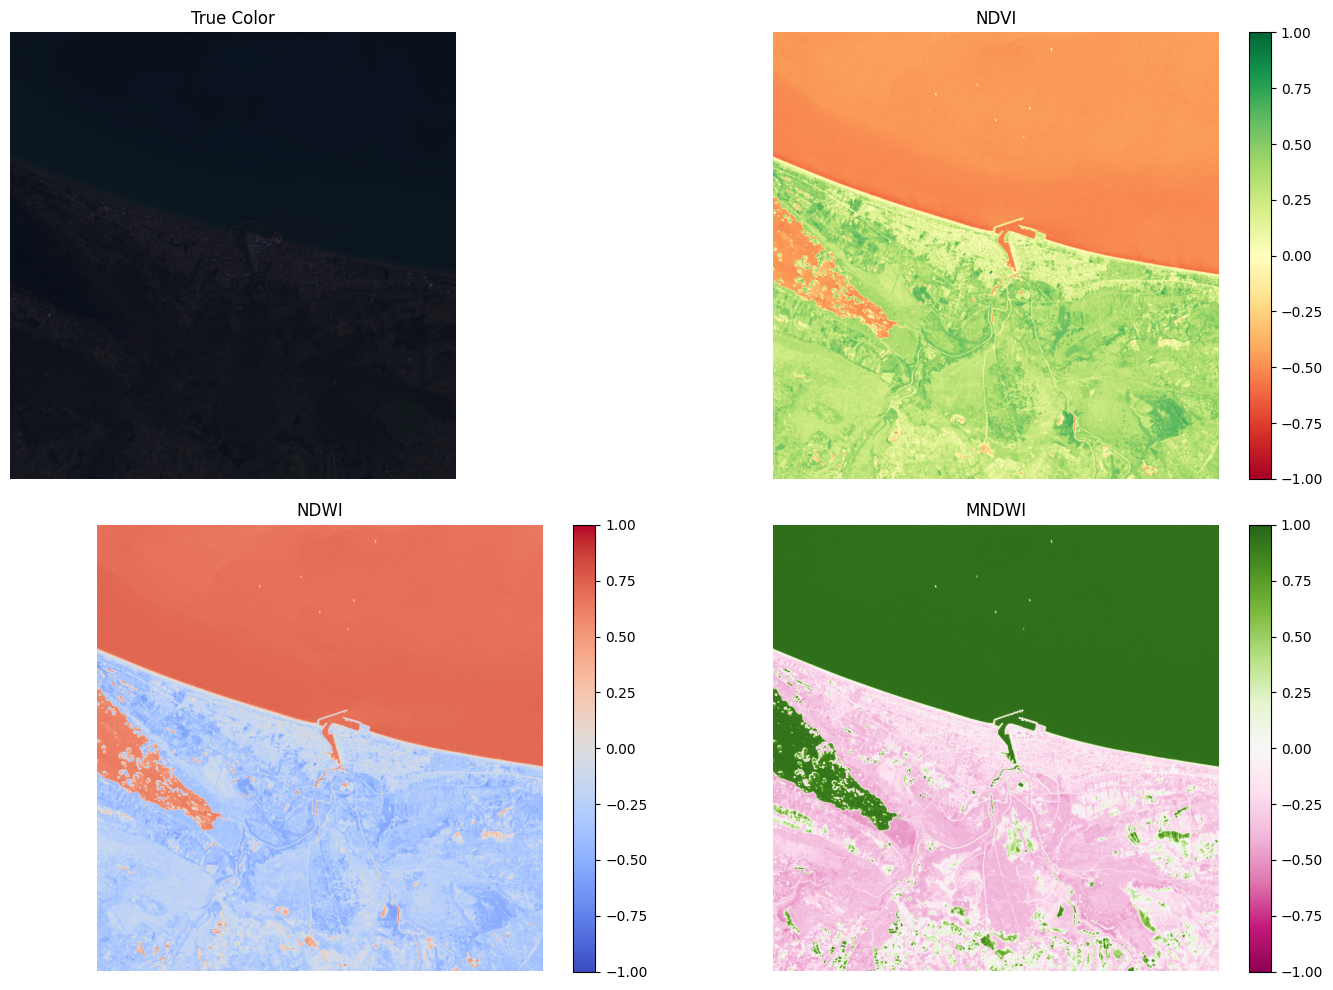

In [13]:
# Function to create and save static maps for each index
def create_static_maps():
    # Create a figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # True color image
    true_color = geemap.ee_to_numpy(
        landsat.select(['B4', 'B3', 'B2']),
        region=bandar_anzali,
        scale=30 # Changed dimensions to scale
    )
    axs[0, 0].imshow(true_color)
    axs[0, 0].set_title('True Color')
    axs[0, 0].axis('off')

    # NDVI
    ndvi_img = geemap.ee_to_numpy(
        landsat_with_indices.select('NDVI'),
        region=bandar_anzali,
        scale=30 # Changed dimensions to scale
    )
    ndvi_plot = axs[0, 1].imshow(ndvi_img, cmap='RdYlGn', vmin=-1, vmax=1)
    axs[0, 1].set_title('NDVI')
    axs[0, 1].axis('off')
    fig.colorbar(ndvi_plot, ax=axs[0, 1], fraction=0.046, pad=0.04)

    # NDWI
    ndwi_img = geemap.ee_to_numpy(
        landsat_with_indices.select('NDWI'),
        region=bandar_anzali,
        scale=30 # Changed dimensions to scale
    )
    ndwi_plot = axs[1, 0].imshow(ndwi_img, cmap='coolwarm', vmin=-1, vmax=1)
    axs[1, 0].set_title('NDWI')
    axs[1, 0].axis('off')
    fig.colorbar(ndwi_plot, ax=axs[1, 0], fraction=0.046, pad=0.04)

    # MNDWI
    mndwi_img = geemap.ee_to_numpy(
        landsat_with_indices.select('MNDWI'),
        region=bandar_anzali,
        scale=30 # Changed dimensions to scale
    )
    mndwi_plot = axs[1, 1].imshow(mndwi_img, cmap='PiYG', vmin=-1, vmax=1)
    axs[1, 1].set_title('MNDWI')
    axs[1, 1].axis('off')
    fig.colorbar(mndwi_plot, ax=axs[1, 1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.savefig('bandar_anzali_indices.png', dpi=300)
    plt.show()

# Create static maps
create_static_maps()